### Libs

In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import pandas_datareader as pdr
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr


# Functions

In [34]:
def pretty_print_conf_matrix(y_true, y_pred, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

# return a daily percentage 
def pct(df):
  lst = [0]
  for i in range(1,len(df)):
    lst.append(df[i]/df[i-1]-1)
  return lst

# inputs list of percentages and returns simulated growth of $100 
def growth(lst):
  start = 100
  growth_list = [100]
  for i in range(1,len(lst)):
    start += start*lst[i]
    growth_list.append(start)
  return growth_list

def accum(gdxP, gldP, days, multiplier): #growth since 'days' day ago (excluding today) of gld*m - gdx
  accum = days*[0]
  i = days
  while i < len(gdxP):
    afl = [multiplier*y-x for x,y in zip(list(gdxP[i-days:i]),list(gldP[i-days:i]))]
    accum.append(growth(afl)[-1])
    i += 1
  return accum

def correl(gdxP, gldP, days): # return Pearson correlation since 'days' day ago (excluding today)
  correl = days*[0]
  i = days
  while i < len(gdxP):
    corr, _ = pearsonr(gdxP[i-days:i], gldP[i-days:i])
    correl.append(corr)
    i += 1
  return correl

# Plotting and Correlations

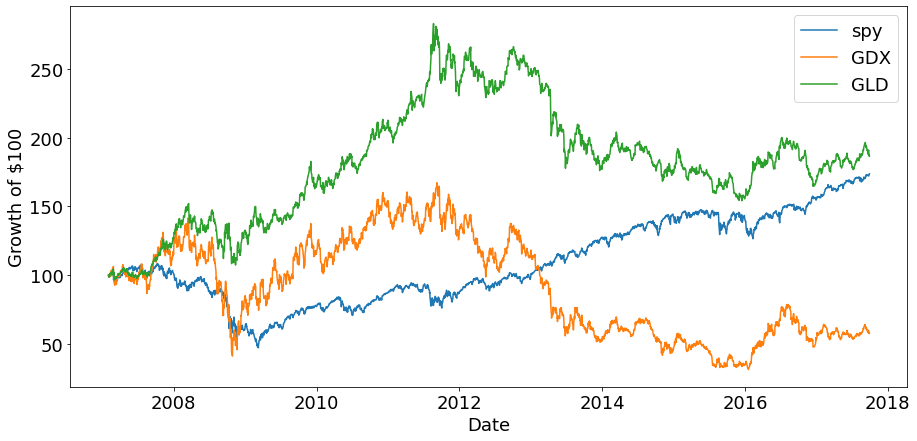

In [8]:
spy = pdr.get_data_yahoo('spy', start = '2007-02-01', end = '2017-10-1')
gld = pdr.get_data_yahoo('gld', start = '2007-02-01', end = '2017-10-1')
gdx = pdr.get_data_yahoo('gdx', start = '2007-02-01', end = '2017-10-1')
gdx['Date'] = gdx.index

spy['growth'] = growth(pct(spy['Close']))
gld['growth'] = growth(pct(gld['Close']))
gdx['growth'] = growth(pct(gdx['Close']))
plt.figure(figsize=(15,7))
plt.plot(spy.growth)
plt.plot(gdx.growth)
plt.plot(gld.growth)
plt.legend(['spy', 'GDX', 'GLD'])
plt.xlabel('Date')
plt.ylabel('Growth of $100')
plt.rcParams.update({'font.size': 18})

In [12]:
df = gdx[['Date']].copy(deep = True)
df['p_spy'] = (pct(spy['Close']))
df['p_gld'] = (pct(gld['Close']))
df['p_gdx'] = (pct(gdx['Close']))

df.head()

,Date,p_spy,p_gld,p_gdx
Date,,,,
2007-02-01,2007-02-01,0.000000,0.000000,0.000000
2007-02-02,2007-02-02,0.001383,-0.014413,-0.013300
2007-02-05,2007-02-05,0.000276,0.000467,0.004069
2007-02-06,2007-02-06,0.000276,0.007464,0.006332
2007-02-07,2007-02-07,0.002209,-0.002470,-0.010571


Pearsons correlation spy/gdx: 29.9% spy/gld 2.9% and gld/gdx: 76.3%


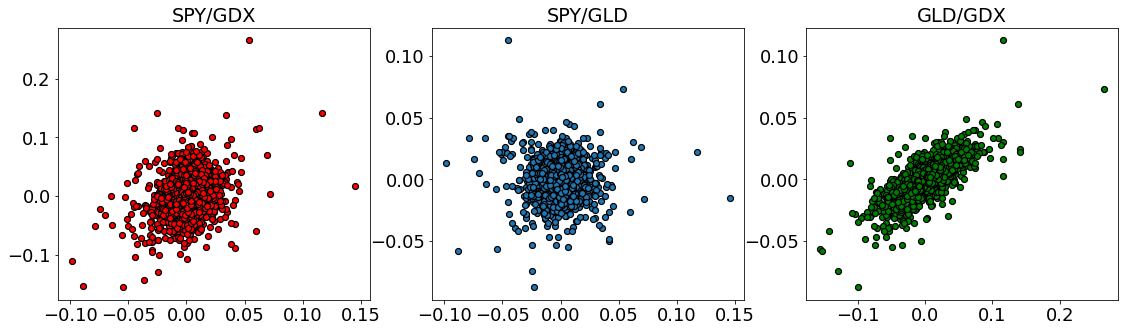

In [ ]:
fig, ax = plt.subplots(1, 3,  figsize=(19,5))# returns a tuple, the 1st is figure object
#fig.subplots_adjust(hspace= 0.3, wspace=0.10)
plt.rcParams.update({'font.size': 16})
ax[0].scatter(spy.pct, gdx.pct, color = 'red',edgecolor='black', linewidth=1.2)
ax[0].set_title('SPY/GDX')
ax[1].scatter(spy.pct,gld.pct,edgecolor='black', linewidth=1.2)
ax[1].set_title('SPY/GLD')
ax[2].scatter(gdx.pct,gld.pct, color = 'green',edgecolor='black', linewidth=1.2)
ax[2].set_title('GLD/GDX');
corr_s_gx, _ = pearsonr(spy.pct, gdx.pct)
corr_s_gl, _ = pearsonr(spy.pct, gld.pct)
corr_gx_gl, _ = pearsonr(gdx.pct, gld.pct)

print('Pearsons correlation spy/gdx: {}% spy/gld {}% and gld/gdx: {}%'.format(round(corr_s_gx*100,1),
                                                          round(corr_s_gl*100,1), round(corr_gx_gl*100,1)))

# Accumulation

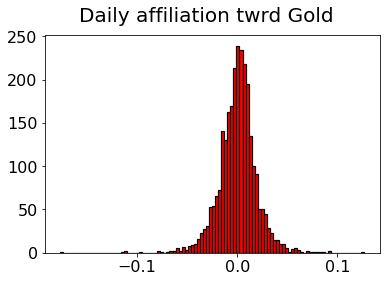

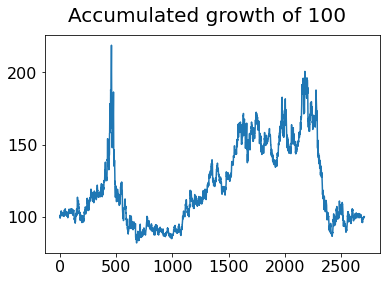

In [ ]:
mult = 1.2
afl = [mult*y-x for x,y in zip(list(gdx['pct']),list(gld['pct']))]
plt.hist(afl, 100,edgecolor='black', linewidth=1.2, color= 'red');
plt.suptitle('Daily affiliation twrd Gold', fontsize=20)
plt.show()
plt.plot(growth(afl))
plt.suptitle('Accumulated growth of 100', fontsize=20);

In [36]:

multiplier = 1.2
df = df.drop('Date', axis = 1)
df['acc_5'] = accum(df['p_gdx'], df['p_gld'], 5, multiplier)
df['acc_10'] = accum(df['p_gdx'], df['p_gld'], 10, multiplier)
df['acc_20'] = accum(df['p_gdx'], df['p_gld'], 20, multiplier)
df['corr_5'] = correl(df['p_gdx'], df['p_gld'], 5)
df['corr_10'] = correl(df['p_gdx'], df['p_gld'], 10)
df['corr_20'] = correl(df['p_gdx'], df['p_gld'], 20)
df.head(12)

,p_spy,p_gld,p_gdx,acc_5,acc_10,acc_20,corr_5,corr_10,corr_20
Date,,,,,,,,,
2007-02-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2007-02-02,0.001383,-0.014413,-0.013300,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2007-02-05,0.000276,0.000467,0.004069,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2007-02-06,0.000276,0.007464,0.006332,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2007-02-07,0.002209,-0.002470,-0.010571,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2007-02-08,-0.001308,0.013771,0.024167,100.268472,0.000000,0.0,0.867269,0.000000,0.0
2007-02-09,-0.007447,0.009158,-0.003726,99.901379,0.000000,0.0,0.918094,0.000000,0.0
2007-02-12,-0.003404,-0.006806,-0.012466,101.728393,0.000000,0.0,0.749523,0.000000,0.0
2007-02-13,0.008435,0.002589,0.015653,101.898272,0.000000,0.0,0.858683,0.000000,0.0


In [42]:
99.901379/100.268472-1

-0.0036611009690065144

In [46]:
cols = ['acc_5', 'acc_10', 'acc_20', 'corr_5', 'corr_10', 'corr_20']
for col in cols:
  df[col] = pct(df[col])
df.head(12)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


,p_spy,p_gld,p_gdx,acc_5,acc_10,acc_20,corr_5,corr_10,corr_20
Date,,,,,,,,,
2007-02-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2007-02-02,0.001383,-0.014413,-0.013300,NaN,NaN,NaN,NaN,NaN,NaN
2007-02-05,0.000276,0.000467,0.004069,NaN,NaN,NaN,NaN,NaN,NaN
2007-02-06,0.000276,0.007464,0.006332,NaN,NaN,NaN,NaN,NaN,NaN
2007-02-07,0.002209,-0.002470,-0.010571,NaN,NaN,NaN,NaN,NaN,NaN
2007-02-08,-0.001308,0.013771,0.024167,inf,NaN,NaN,inf,NaN,NaN
2007-02-09,-0.007447,0.009158,-0.003726,-0.003661,NaN,NaN,0.058603,NaN,NaN
2007-02-12,-0.003404,-0.006806,-0.012466,0.018288,NaN,NaN,-0.183610,NaN,NaN
2007-02-13,0.008435,0.002589,0.015653,0.001670,NaN,NaN,0.145639,NaN,NaN


In [63]:
df['target'] = [0] + list(df['acc_5'][:-1])
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

df.head(10)

,p_spy,p_gld,p_gdx,acc_5,acc_10,acc_20,corr_5,corr_10,corr_20,target
Date,,,,,,,,,,
2007-02-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-03-05,-0.009519,-0.012243,-0.020170,0.004804,-0.006294,0.003087,-0.017814,0.002067,0.004973,-0.000373
2007-03-06,0.017110,0.019387,0.031419,-0.017548,0.003453,0.009019,-0.002289,0.000850,0.004493,0.004804
2007-03-07,-0.001002,0.002338,0.000263,-0.011482,-0.008460,-0.010752,0.011837,0.003295,0.005662,-0.017548
2007-03-08,0.008455,0.002799,0.006826,-0.006489,0.011746,-0.005026,-0.001350,-0.005651,-0.000036,-0.011482
2007-03-09,0.000284,-0.003567,-0.008344,-0.002548,-0.012814,0.004207,0.010625,0.008288,0.000752,-0.006489
2007-03-12,0.001492,0.001868,0.016303,-0.001407,0.009817,-0.010497,0.007796,0.006413,-0.001845,-0.002548
2007-03-13,-0.019434,-0.010098,-0.038810,-0.005955,-0.036640,-0.018282,-0.096209,-0.011208,0.004830,-0.001407
2007-03-14,0.007450,0.003453,0.005653,0.024088,0.023248,0.039737,0.051076,-0.066196,-0.018720,-0.005955


In [52]:
[0] + target

Date
2007-02-01    0.000000
2007-02-02         NaN
2007-02-05         NaN
2007-02-06         NaN
2007-02-07         NaN
                ...   
2017-09-22   -0.000638
2017-09-25   -0.011057
2017-09-26   -0.000230
2017-09-27    0.001694
2017-09-28    0.000895
Name: acc_5, Length: 2685, dtype: float64

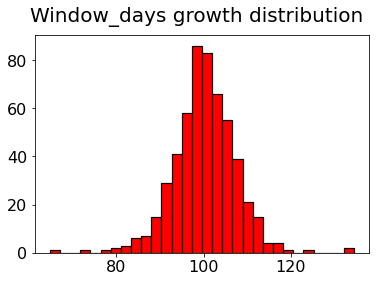

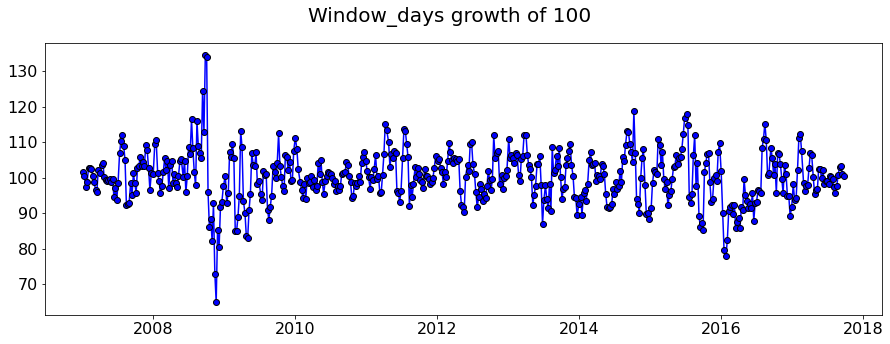

In [ ]:
accum =[]
date = []
mult = 1.2
window = 20
overlap = 5
n_win = int(len(gdx)/window)*2
i = 0
while i < len(gdx)- overlap:
  afl = [mult*y-x for x,y in zip(list(gdx.pct[i:i+window]),list(gld.pct[i:i+window]))]
  accum.append(growth(afl)[-1])
  date.append(gdx['Date'][i])
  i += overlap
plt.hist(accum,30,edgecolor='black', linewidth=1.2, color= 'red');
plt.suptitle('Window_days growth distribution', fontsize=20);
plt.figure(figsize=(15,5))
plt.plot(date, accum, marker = 'o', color = 'blue', mec = 'black')
plt.suptitle('Window_days growth of 100', fontsize=20);

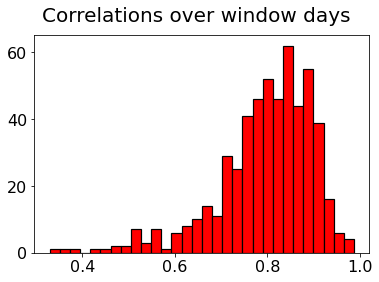

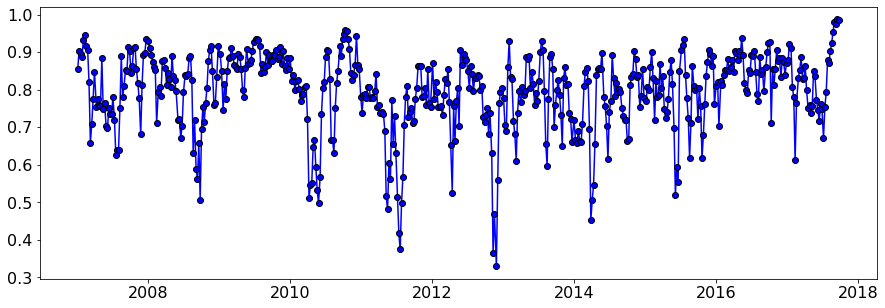

In [ ]:
corels =[]
date = []
window = 20
overlap = 5
n_win = int(len(gdx)/window)*2
i = 0
while i < len(gdx)-overlap:
  corr, _ = pearsonr(gdx.pct[i:i+window], gld.pct[i:i+window])
  date.append(gdx['Date'][i])
  i += overlap
  corels.append(corr)
plt.hist(corels,30,edgecolor='black', linewidth=1.2, color= 'red')
plt.suptitle('Correlations over window days', fontsize=20);
plt.figure(figsize=(15,5))
plt.plot(date, corels, marker = 'o', color = 'blue', mec = 'black');

In [ ]:
corr, _ = pearsonr(accum, corels)
corr

-0.21767018344575262

In [ ]:
a = [1,2,3,4,5,-1,-2,-3]
b = [2,4,6,8,10,-2,0,-3]
corr, _ = pearsonr(a,b)
corr

0.9726189054925081

### Long term does not work

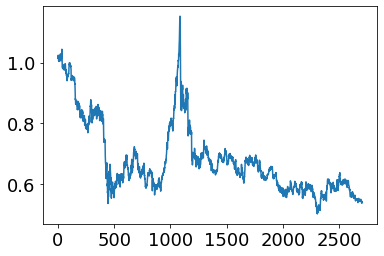

In [ ]:
accum = 1
mult = 1.4
acc_list = []
for i in range(len(p_gdx)):
  accum += accum*(p_gdx[i]-p_gld[i]*mult)
  acc_list.append(accum)
plt.plot(acc_list)

,pct_gdx,pct_gld,gdx_shifted_1,one,two,four,eight,sixteen,aff_1_shifted,aff_2_shifted,aff_4_shifted,pct_spy
0,0.001752,-0.010116,-0.032194,-0.016925,0.000000,0.000000,0.000000,0.0,-0.003816,0.000380,-0.009609,0.002122
1,-0.032194,-0.024007,0.003532,-0.003816,-0.020741,0.000000,0.000000,0.0,0.004196,-0.003569,0.001905,-0.007976
2,0.003532,0.005152,0.016942,0.004196,0.000380,0.000000,0.000000,0.0,-0.007766,-0.009990,-0.004061,0.004625
3,0.016942,0.006118,-0.004185,-0.007766,-0.003569,-0.024310,0.000000,0.0,-0.002224,0.005474,0.017502,-0.000850
4,-0.004185,-0.004273,-0.006708,-0.002224,-0.009990,-0.009609,0.000000,0.0,0.007698,0.005929,0.020396,0.003332
5,-0.006708,0.000660,0.039870,0.007698,0.005474,0.001905,0.000000,0.0,-0.001770,0.012028,0.014197,0.004380
6,0.039870,0.025400,-0.018623,-0.001770,0.005929,-0.004061,0.000000,0.0,0.013797,0.014467,0.018004,0.007597
7,-0.018623,-0.003217,0.015548,0.013797,0.012028,0.017502,-0.006809,0.0,0.000670,0.002169,-0.008163,-0.001955


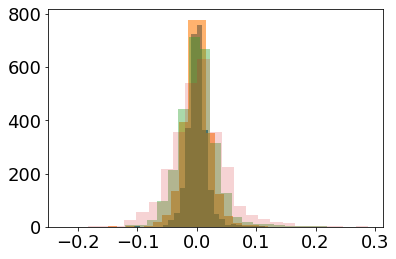

In [ ]:
def affinity(p_gld, p_gdx, multiplier, days):
  tendency = [0]*(days-1)
  for i in range(days-1, len(p_gld)):
    tendency.append(sum(p_gld[i+1-days:i+1])*multiplier-sum(p_gdx[i+1-days:i+1]))
  return tendency

aff_1 = affinity(p_gld, p_gdx, 1.5, 1)   
aff_2 = affinity(p_gld, p_gdx, 1.5, 2)
aff_4 = affinity(p_gld, p_gdx, 1.5, 4)
aff_8 = affinity(p_gld, p_gdx, 1.5, 8)
aff_16 = affinity(p_gld, p_gdx, 1.5, 16)
aff_1_shifted = aff_1 + [0]
aff_1_shifted = aff_1_shifted[1:]
aff_2_shifted =  aff_2 + [0, 0]
aff_2_shifted = aff_2_shifted[2:]
aff_4_shifted =  aff_4 +[0,0,0,0]
aff_4_shifted = aff_4_shifted[4:]
gdx_shifted_1 = p_gdx + [0]
gdx_shifted_1 = gdx_shifted_1[1:]
df = pd.DataFrame(list(zip(p_gdx,p_gld,gdx_shifted_1, aff_1, aff_2, aff_4, aff_8,
                           aff_16, aff_1_shifted, aff_2_shifted, aff_4_shifted, p_spy)),
                  columns=['pct_gdx', 'pct_gld', 'gdx_shifted_1', 'one', 'two', 'four', 'eight', 'sixteen', 'aff_1_shifted', 'aff_2_shifted', 'aff_4_shifted', 'pct_spy'])
plt.hist(aff_2, bins=25)
plt.hist(aff_4, bins=25, alpha = 0.6)
plt.hist(aff_8, bins=25, alpha = 0.4)
plt.hist(aff_16, bins=25, alpha = 0.2);
df.head(8)

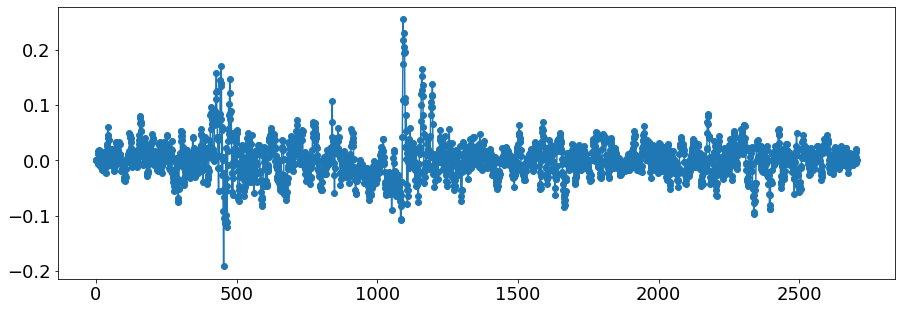

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df['eight'], marker ='o');
#plt.axis([2000,2500,-0.2, 0.2])

### Clustering Visualization

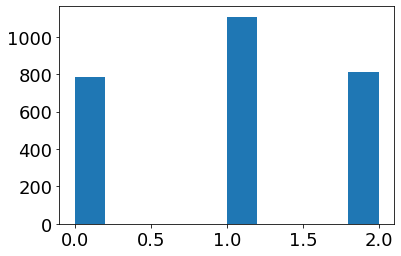

In [ ]:
labels = []
for i in range(len(df)):
  if df.aff_4_shifted[i] > 0.01:
    labels.append(2)
  elif df.aff_4_shifted[i] > 0 and df.aff_4_shifted[i]< 0.01:
    labels.append(1)
  elif df.aff_4_shifted[i] > -0.01 and df.aff_4_shifted[i]< 0:
    labels.append(1)
  else:
    labels.append(0)
plt.hist(labels);

#### PCA

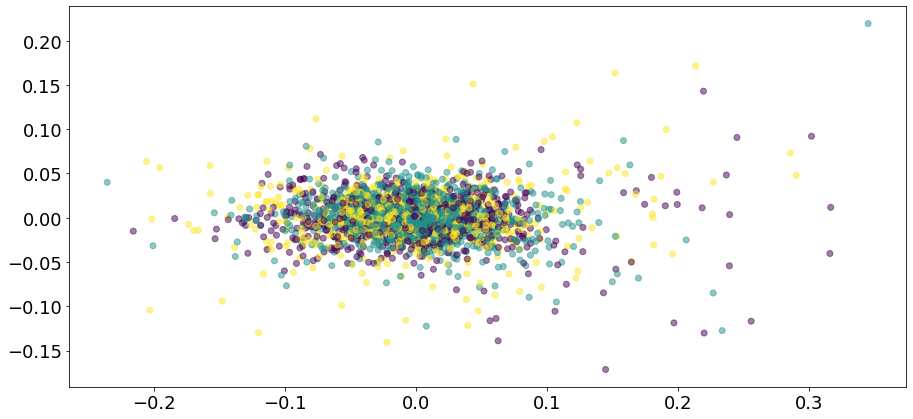

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(np.column_stack((p_gdx,p_gld, aff_1, aff_2, aff_4, aff_8, aff_16, p_spy)))
pdf = pd.DataFrame(data = principalComponents
             , columns = ['one', 'two'])
a = pdf['one'].tolist()
b = pdf['two'].tolist()
plt.figure(figsize=(15,7))
plt.scatter(a,b, c = labels, alpha = 0.5);
#plt.axis([-0.1,0.1, -0.1,0.1]);

### TSNE

t-SNE done! Time elapsed: 50.57923769950867 seconds


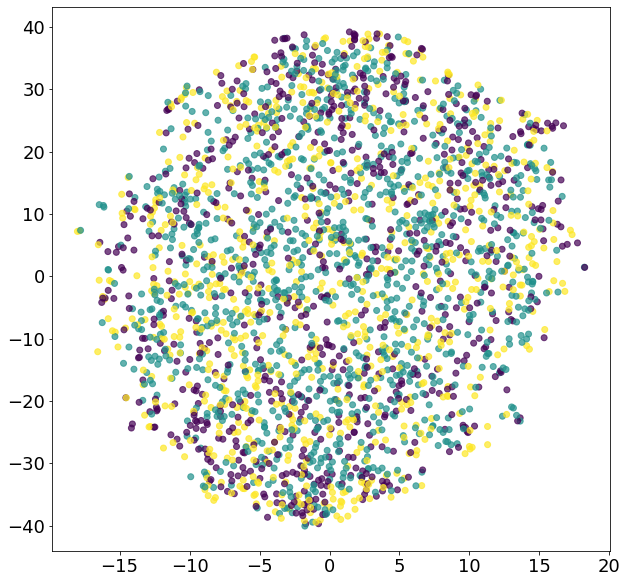

In [ ]:
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=100, n_iter=500)
tsne_results = tsne.fit_transform(np.column_stack((df['pct_gdx'], df['pct_gld'], df['one'], df['two'], df['four'], df['eight'], df['sixteen'])))
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
pdf = pd.DataFrame(data = tsne_results, columns = ['one', 'two'])
a = pdf['one'].tolist()
b = pdf['two'].tolist()
plt.figure(figsize=(10,10))
plt.scatter(a,b, c = labels, alpha = 0.7)

### KNN

In [ ]:

x = np.column_stack((df['one'], df['two'], df['four'], df['eight'], df['sixteen']))
y = np.asarray(labels)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
K_value = []
for K in range(1,20):
    K = K+1
    model = neighbors.KNeighborsClassifier(n_neighbors = K)
    model.fit(x_train, y_train)  
    prediction_train = model.predict(x_train)
    prediction_test = model.predict(x_test)
    print(K, ' train:', accuracy_score(prediction_train, y_train))
    print('test:', accuracy_score(prediction_test, y_test), '\n')

In [ ]:
labels = [0] + labels
labels = labels[:-1]

### Rf

In [ ]:
x = np.column_stack((df['pct_gdx'], df['pct_gld'],df['one'], df['two'], df['four'], df['eight'], df['sixteen'], df['pct_spy']))
y = np.asarray(labels)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=40)
n_estimators, max_depths, min_samples_split, min_samples_leaf = [300], [40], [30], [4]

for estimators in n_estimators:   
    for max_depth in max_depths:
        for min_sample_split in min_samples_split:
            for min_sample_leaf in min_samples_leaf:
                start_time = time.time()
                model = RandomForestClassifier(n_estimators = estimators, max_depth = max_depth,
                   min_samples_split = min_sample_split, min_samples_leaf = min_sample_leaf, random_state = 13)
                model.fit(x_train, y_train)  
                prediction_train = model.predict(x_train)
                prediction_test = model.predict(x_test)
                print(accuracy_score(y_train, prediction_train),
        accuracy_score(y_test, prediction_test),estimators, max_depth, min_sample_split,min_sample_leaf)

0.7536968576709797 0.42513863216266173 300 40 30 4


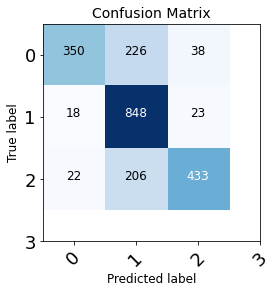

In [ ]:
pretty_print_conf_matrix(y_train,prediction_train, classes= list(range(4)),normalize=False, title='Confusion Matrix')

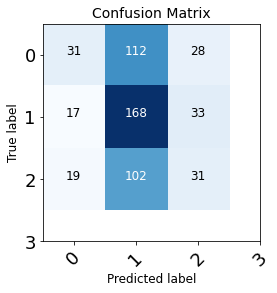

In [ ]:
pretty_print_conf_matrix(y_test,prediction_test, classes= list(range(4)),normalize=False, title='Confusion Matrix')

### ANN

Train on 2164 samples, validate on 541 samples
Epoch 1/150
2164/2164 [==============================] - 0s 70us/step - loss: 1.0988 - accuracy: 0.3415 - val_loss: 1.0978 - val_accuracy: 0.3900
Epoch 2/150
2164/2164 [==============================] - 0s 47us/step - loss: 1.0980 - accuracy: 0.3410 - val_loss: 1.0972 - val_accuracy: 0.3826
Epoch 3/150
2164/2164 [==============================] - 0s 44us/step - loss: 1.0977 - accuracy: 0.3429 - val_loss: 1.0958 - val_accuracy: 0.3900
Epoch 4/150
2164/2164 [==============================] - 0s 43us/step - loss: 1.0977 - accuracy: 0.3512 - val_loss: 1.0966 - val_accuracy: 0.4085
Epoch 5/150
2164/2164 [==============================] - 0s 43us/step - loss: 1.0972 - accuracy: 0.3558 - val_loss: 1.0959 - val_accuracy: 0.4011
Epoch 6/150
2164/2164 [==============================] - 0s 42us/step - loss: 1.0971 - accuracy: 0.3484 - val_loss: 1.0960 - val_accuracy: 0.3974
Epoch 7/150
2164/2164 [==============================] - 0s 42us/step - loss:

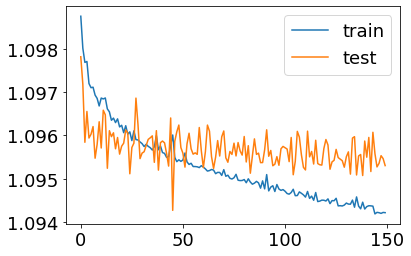

541/541 [==============================] - 0s 33us/step
0.01 300 128 Accuracy: 38.82%


In [ ]:
y = np.asarray(labels)
softmax_units = 3
#for loops were used to get to these optimal values for units, lr, epochs, etc:
units = [300]
epochs = 150
batch_sizes = [128]
lrs = [0.01]

for lr in lrs:
    for unit in units:
        for batch_size in batch_sizes:
            model_nn = Sequential()
            model_nn.add(Dense(units = unit,input_dim = 8, activation='relu'))
            #model_nn.add(Dropout(0.9))
            model_nn.add(Dense(units = unit,input_dim = 8, activation='relu'))
            #model_nn.add(Dropout(0.9))
            model_nn.add(Dense(units = softmax_units,  activation='softmax'))
            opt = SGD(lr=lr, momentum=0.9, decay=0.001)
            model_nn.compile(optimizer = opt, loss='sparse_categorical_crossentropy' ,  metrics=['accuracy'])
            history = model_nn.fit(x_train, y_train, epochs = epochs, batch_size = batch_size,
                                   validation_data=(x_test, y_test), verbose = 1, shuffle=True)
            pyplot.plot(history.history['loss'], label='train')
            pyplot.plot(history.history['val_loss'], label='test')
            pyplot.legend()
            pyplot.show()
            scores = model_nn.evaluate(x_test, y_test, verbose=1)
            print(lr,unit, batch_size, "Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
for i in range(100,210):
  print('GLD: %.2f%% => GDX: %.2f%% ,,, spy:  %2f%% \n' %(df.pct_gld[i]*100, df.pct_gdx[i]*100, df.pct_spy[i]*100))

GLD: -0.54% => GDX: 0.11% ,,, spy:  0.814497% 

GLD: 1.27% => GDX: 3.08% ,,, spy:  -0.104241% 

GLD: 1.37% => GDX: 2.30% ,,, spy:  0.495692% 

GLD: 0.15% => GDX: -0.02% ,,, spy:  0.012983% 

GLD: -0.26% => GDX: -0.80% ,,, spy:  -0.395847% 

GLD: 0.06% => GDX: -1.01% ,,, spy:  -1.074995% 

GLD: -1.73% => GDX: -3.36% ,,, spy:  -1.804525% 

GLD: -1.59% => GDX: 0.74% ,,, spy:  1.301132% 

GLD: 0.75% => GDX: -0.16% ,,, spy:  0.172146% 

GLD: -0.93% => GDX: -2.09% ,,, spy:  -1.090555% 

GLD: 0.67% => GDX: 1.50% ,,, spy:  1.496830% 

GLD: 0.11% => GDX: 1.03% ,,, spy:  0.638621% 

GLD: 0.39% => GDX: 1.85% ,,, spy:  0.137385% 

GLD: 0.15% => GDX: -0.28% ,,, spy:  -0.117598% 

GLD: 0.82% => GDX: 1.26% ,,, spy:  0.248548% 

GLD: -1.18% => GDX: -1.98% ,,, spy:  -1.389708% 

GLD: -0.23% => GDX: 1.19% ,,, spy:  0.555774% 

GLD: 0.34% => GDX: -0.92% ,,, spy:  -0.940908% 

GLD: -0.54% => GDX: -2.42% ,,, spy:  -0.478247% 

GLD: -1.26% => GDX: -1.98% ,,, spy:  -1.027837% 

GLD: 0.08% => GDX: 0.81% ,,, s